# NumPy Based CNN block (10 points)

##   Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network

1. **`zero padding`**

2. **`convolution : Forward`**

3. **`convolution : Backward`**

4. **`Max pooling : Forward`**

5. **`Max pooling : Backward`**


    
This notebook will ask you to implement these functions from scratch in **`Numpy`**.


**Note** that for every forward function, there is its corresponding backward equivalent. 

In [3]:
import typing as tg
import torch
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

## 1. Zero Padding (1 pts.)

Zero-padding adds zeros around the border of an image:

**Exercise**  : Implement the following function, which pads all the images of a batch of examples X with zeros.

shape of X and its zero pad array is :


$$ X : (N, C, i_h, i_w)   $$
$$  \text{zeropad}(X) : (N, C, i_h + 2*ph, i_w + 2*pw)$$

**Note** : you should not use np.pad in your implementation

In [4]:
def zero_padding(X: npt.NDArray, padding: tg.Tuple[int, int]):
    """
    Pad with zeros all images of the dataset X.
    The padding is applied to the height and width of an image.

    Parameters
    ----------
    X : npt.NDArray
        numpy array of shape (N, C, IH, IW) representing a batch of N images
    padding : tuple int
        (ph, pw), amount of padding around each image on vert and hor dims

    Returns
    -------
    zero_pad : npt.NDArray
        zero pad array of shape (N, C, IH + 2*ph, IW + 2*pw)
    """

    zero_pad: npt.NDArray = np.zeros(
        (
            X.shape[0],
            X.shape[1],
            X.shape[2] + 2 * padding[0],
            X.shape[3] + 2 * padding[1],
        ),
        dtype=X.dtype,
    )
    zero_pad[:, :, padding[0] : -padding[0], padding[1] : -padding[1]] = X
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return zero_pad

your implementation is correct
shape of x is : (2, 3, 4, 4)
shape of x_pad is : (2, 3, 10, 8)


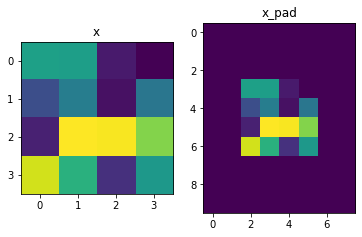

In [5]:
# test zero_padding function
np.random.seed(1968)

x = np.random.rand(2, 3, 4, 4)
padding = (3, 2)
x_pad = zero_padding(x, padding)


assert x_pad.shape == (
    x.shape[0],
    x.shape[1],
    x.shape[2] + 2 * padding[0],
    x.shape[3] + 2 * padding[1],
)
assert np.all(
    x_pad[
        :, :, padding[0] : padding[0] + x.shape[2], padding[1] : padding[1] + x.shape[3]
    ]
    == x
)

print("your implementation is correct")
print("shape of x is :", x.shape)
print("shape of x_pad is :", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title("x")
axarr[0].imshow(x[0, 0, :, :])
axarr[1].set_title("x_pad")
axarr[1].imshow(x_pad[0, 0, :, :])

## 2.convolution : Forward (2 pts.)

In this Exercise, you implement convolutional neural networks using the NumPy library only.

The input X,W are the input of the convolutional layer and the shape of X,W are $(N, C, i_h, i_w)$ , $(F, C, f_h, f_w)$ respectively and The return  value O is the output of the convolutional layer and the shape is $(N, F, O_h, O_w)$ where :

$$\text{stride} : (s_h,s_w)$$

$$\text{padding} : (p_h,p_w)$$

$$O_w =\lfloor \frac{i_w - f_w + 2*p_w}{s_w} \rfloor + 1$$

$$O_h = \lfloor\frac{i_h - f_h + 2*p_h}{s_h}\rfloor + 1$$
$$O(b,f, i ,j)=\sum_{r=0}^{C-1}\sum_{k=0}^{f_h-1}\sum_{l=0}^{f_w-1} W(f,r,k,l) X(b,r,s_h *i +k, s_w  *j +l)$$

In [8]:
def convolution2D(X, W, stride, padding):
    """
    A implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height IH and
    width IW. We convolve each input with F different filters, where each filter
    spans all C channels and has height FH and width FW.


    Parameters
    ----------
    X : npt.NDArray
        input data of shape (N, C, IH, IW)
    W : npt.NDArray
        Filter weight of shape (F, C, FH, FW)
    stride : tuple of int
        a tuple of 2 integer (sh, sw)
    padding : tuple int
        (ph, pw), amount of padding around each image on vert and hor dims

    Returns
    -------
    out : npt.NDArray
        Output data, of shape (N, F, OH, OW) where OH and OW given by
            OH= 1 + int ( (IH + 2*ph - FH)/ sh )
            OW= 1 + int ( (IW + 2*pw - FW)/ sw )
    """
    out: npt.NDArray[np.float64] = np.zeros(
        (
            X.shape[0],
            W.shape[0],
            int((X.shape[2] - W.shape[2] + 2 * padding[0]) / stride[0] + 1),
            int((X.shape[3] - W.shape[3] + 2 * padding[1]) / stride[1] + 1),
        ),
        dtype=np.float64,
    )

    X = zero_padding(X, padding)
    for b in range(out.shape[0]):
        for f in range(out.shape[1]):
            for i in range(out.shape[2]):
                for j in range(out.shape[3]):
                    out[b, f, i, j] = np.sum(
                        X[
                            b,
                            :,
                            i * stride[0] : i * stride[0] + W.shape[2],
                            j * stride[1] : j * stride[1] + W.shape[3],
                        ]
                        * W[f, :, :, :],
                        dtype=np.float64,
                    )
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out

To test your implementation, we will compare the results  with torch function (torch.nn.functional.conv2d)

In [11]:
np.random.seed(1973)
param1 = {
    "X": np.random.rand(2, 3, 23, 20),
    "W": np.random.rand(7, 3, 6, 6),
    "stride": (3, 6),
    "padding": (2, 3),
}

w_t = torch.from_numpy(param1["W"]).float()
x_t = torch.from_numpy(
    np.pad(param1["X"], ((0, 0), (0, 0), (2, 2), (3, 3)), "constant", constant_values=0)
).float()
conv = torch.nn.functional.conv2d(x_t, w_t, stride=param1["stride"], padding="valid")
conv = conv.cpu().detach().numpy()

conv_numpy = convolution2D(**param1)

assert conv.shape == conv_numpy.shape
print("Error :", (np.sum(conv - conv_numpy) ** 2))
print("output shape :", conv_numpy.shape)

Error : 1.3506110470706943e-08
output shape : (2, 7, 8, 4)


** Expected Output: **
<table>
    <tr>
        <td>
            **out shape**
        </td>
        <td>
            (2, 7, 8, 4)
        </td>
    </tr>
    <tr>
        <td>
            **ERROR**
        </td>
        <td>
            2.5559093329160782e-28
       </td>
    </tr>
    
</table>


## 3.convolution : Backward

### 3.1 - Backward  w.r.t. filter (3 pts.)

This is the formula for computing a $\frac{\partial L}{\partial W}$ for a single $W(f^\prime,c^\prime,k^\prime ,l^\prime )$ that $W$ is 4-D array as a filter in convolution operation with shape $(F,C,f_h,f_w)$ 

$$\frac{\partial L}{\partial W(f^\prime,c^\prime,k^\prime ,l^\prime )} = \sum_{b=0}^{N-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b,f^\prime,i,j)} \frac{\partial O(i,j)}{\partial W(f^\prime,c^\prime,k^\prime ,l^\prime )}\right ) = \sum_{b=0}^{N-1}\left (\sum_{i=0}^{O_w-1}\sum_{j=0}^{O_h-1} \frac{\partial L}{\partial O(b,f^\prime,i,j)}  X(b,c^\prime, s_h*i +k^\prime, s_w*j +l^\prime) \right )$$


In [ ]:
def convolution2D_backward_filter(out_grad, X, W, stride):
    """
    A implementation of the backward pass for a convolutional layer.

    inputs:
     - out_grad  : gradient of the Loss with respect to the output of the conv layer with shape (N, F, OW, OH)
     - X : input data of shape (N, C, IH, IW)
     - W : Filter weight of shape (F, C, FH, FW)
     - stride : a list of [sh, sw]

    return:
     - dW : Gradient with respect to W

    """
    dW = None
    ###########################################################################
    # Implement the convolutional backward pass.                              #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dW

In [ ]:
np.random.seed(1345)

param = {
    "X": np.random.rand(2, 3, 10, 10),
    "W": np.random.rand(7, 3, 4, 4),
    "stride": (2, 2),
}
c_1 = np.ones((2, 7, 4, 4))
dw = convolution2D_backward_filter(c_1, **param)
w_t = torch.from_numpy(param["W"]).float()
x_t = torch.from_numpy(param["X"]).float()
x_t.requires_grad = True
w_t.requires_grad = True
c = torch.nn.functional.conv2d(x_t, w_t, stride=param["stride"], padding="valid")

loss = c.sum()
loss.backward()
dw_t = w_t.grad.cpu().detach().numpy()


print("Error  :", np.sum((dw - dw_t) ** 2))
print("dW_t  :", np.sum(dw_t))
print("dW  :", np.sum(dw))

** Expected Output: **
<table>
    <tr>
        <td>
            **dW_t**
        </td>
        <td>
            5340.576411697173
        </td>
    </tr>
    <tr>
        <td>
            **dW**
        </td>
        <td>
            5340.576411697173
        </td>
    </tr>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            2.473867798773093e-27
 </td>
    </tr>

</table>


### 3.2 - Backward  w.r.t. input (2 pts.)

This is the formula for computing a $\frac{\partial L}{\partial X}$ for a single $X(b^\prime,c^\prime,k^\prime ,l^\prime )$ that $X$ is 4-D array as a input in convolution operation with shape $(N,C,i_h,i_w)$ 

$$\frac{\partial L}{\partial X(b^\prime,c^\prime,k^\prime ,l^\prime )} = \sum_{f=0}^{F-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b^\prime,f,i,j)} \frac{\partial O(b^\prime,f,i,j)}{\partial X(b^\prime,c^\prime,k^\prime ,l^\prime )}\right ) = \sum_{f=0}^{F-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b^\prime,f,i,j)} W(f,c^\prime,k^\prime - s_h*i, l^\prime - s_w*j) \right )$$


In [ ]:
def convolution2D_backward_input(out_grad, X, W, stride):
    """
    A implementation of the backward pass for a convolutional layer.

    inputs:
     - out_grad  : gradient of the Loss with respect to the output of the conv layer with shape (N, F, OW, OH)
     - X : input data of shape (N, C, IH, IW)
     - W : Filter weight of shape (F, C, FH, FW)
     - stride : a list of [sh, sw]

    return:
     - dX : Gradient with respect to X

    """

    dX = None
    ###########################################################################
    # Implement the convolutional backward pass.                              #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dX

In [ ]:
np.random.seed(1992)

param = {
    "X": np.random.rand(5, 3, 6, 6),
    "W": np.random.rand(2, 3, 2, 2),
    "stride": (3, 3),
}
grad = np.ones((5, 2, 2, 2))
dx = convolution2D_backward_input(grad, **param)


w_t = torch.from_numpy(param["W"]).float()
x_t = torch.from_numpy(param["X"]).float()
x_t.requires_grad = True
w_t.requires_grad = True
c = torch.nn.functional.conv2d(x_t, w_t, stride=param["stride"], padding="valid")

loss = c.sum()
loss.backward()
dx_t = x_t.grad.cpu().detach().numpy()


assert dx.shape == dx_t.shape
print("Error is :", np.sum((dx - dx_t) ** 2))
print("dX_t is :", np.sum(dx_t))
print("dX is :", np.sum(dx))

** Expected Output: **
<table>
    <tr>
        <td>
            **dX_t**
        </td>
        <td>
            208.39287018595633
        </td>
    </tr>
    <tr>
        <td>
            **dX**
        </td>
        <td>
            208.39287018595633
        </td>
    </tr>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            0.0
 </td>
    </tr>

</table>


## 4.Pooling

### 4.1 - forward max pooling (1 pts.)

The pooling layer reduces the height and width of the input. It helps reduce computation

 - Max-pooling layer: slides an ($f, f$) window with stride $s$ over the input and stores the max value of the window in the output.

in function below X is input and shape of X is $(N, C, i_h, i_w)$  and output is shape $(N, C, O_h, O_w)$ that :

 $$O_h =\lfloor\frac{i_h - f }{s}\rfloor + 1$$
 $$O_w =\lfloor\frac{i_w - f }{s}\rfloor + 1$$

**Exercise**: Implement the forward pass of the pooling layer


In [ ]:
def pool_forward(X, f, s):
    """
    Implements the forward pass of the pooling layer

    input:
       - X : numpy array of shape (N, C, IH, IW)
       - f : int, filter size in height and width dim
       - s : int

    Returns:
       - pool : output of the pool layer, a numpy array of shape (N, C, OH, OW) where OH and OW given by

       OH = 1 + int((IH - f)/s)
       OW = 1 + int((IW - f)/s)

    """
    pool = None
    ###########################################################################
    #  Implement the max pooling forward pass.                                #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return pool

In [ ]:
np.random.seed(1975)
x = np.random.rand(2, 3, 23, 23)

hyper_param = {"f": 2, "s": 11}
c = pool_forward(x, **hyper_param)

pooling = torch.nn.MaxPool2d(2, 11)

x_t = torch.from_numpy(x)
x_t.requires_grad = True
pool_t = pooling(x_t).cpu().detach().numpy()

assert c.shape == pool_t.shape
assert (c == pool_t).all()

print("your implementation is correct")
print("output shape :", c.shape)
print("output :", c)
print("Error :", np.sum((c - pool_t) ** 2))

** Expected Output: **
<table>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            0.0
        </td>
    </tr>
    <tr>
        <td>
            **output shape **
        </td>
        <td>
            (2, 3, 2, 2)
        </td>
    </tr>


</table>


### 4.2 - backward max pooling (1 pts.)

**Exercise**  :implement the backward pass for the pooling layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 


In [ ]:
def pool_back(grad_pool, X, f, s):
    """
    Implements the backward pass of the pooling layer

    Arguments:
       - grad_pool : gradient of cost with respect to the output of the pooling layer
       - X : input to pooling layer , numpy array with shape (N, C, IH, IW)
       - f : int, filter size in height and width dim
       - s :  int
    Returns:
       - dX_pool  : gradient of cost with respect to the input of the pooling layer, same shape as X
    """
    dX_pool = None
    ###########################################################################
    # Implement the max pooling backward pass.                               #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dX_pool

In [ ]:
np.random.seed(19)
X = np.random.rand(2, 3, 10, 10)
g = np.random.rand(2, 3, 9, 9)

f = 2
s = 1
dX = pool_back(g, X, f, s)


print("mean of dX :", np.mean(dX))
print("dX[1,2,2:5,2:5] = ", dX[1, 2, 2:5, 2:5])

**Expected Output**: 

<table> 
<tr> 
<td>

**mean of dX =**
</td>

<td>

0.4074887549535014
  </td>
</tr>

<tr> 
<td>
**dX[1,2,2:5,2:5] =** 
</td>
<td>
[[0. 0. 1.20296614] [2.18908689 0. 2.12049676] [0. 1.14564779 0. ]]
</td>
</tr>
</table>

